In [1]:
import time
import torch
import mat73
import numpy as np
import pandas as pd
from torch.utils import data
from torch import nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
from torchvision import transforms

import torch.utils.model_zoo as model_zoo
import torch.onnx

In [2]:
#verify cuda is accesible - if not, check drivers

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
#hyperparameters

HOLD_OUT_VAL = 0.01
HOLD_OUT_TEST = 0.1

BATCH_SIZE = 16
HIDDEN_NODES = 64
LEARNING_RATE = 1e-4

INPUT_NODES = 9
OUTPUT_NODES = 972 + 80
# OUTPUT_NODES = 732

In [4]:
#load the matlab dataset(s)
raw_data = mat73.loadmat("data-training/training_data_landing_normalized.mat")

print(raw_data.keys())

X_data = np.swapaxes(raw_data['training_data_normalized']['input'], 0, 1)
Y_data = np.swapaxes(raw_data['training_data_normalized']['output'], 0, 1)

print('Shape of X_data ' + str(X_data.shape))
print('Shape of Y_data ' + str(Y_data.shape))

dict_keys(['training_data_normalized'])
Shape of X_data (1658, 9)
Shape of Y_data (1658, 1052)


In [5]:
#convert numpy array to pytorch tensor for data

input_data = torch.from_numpy(X_data).float()
output_data = torch.from_numpy(Y_data).float()

In [6]:
#normalize the datasets, if necessary

normalize_data = False

if normalize_data:
    input_mean = torch.mean(input_data,0)
    input_std = torch.std(input_data,0)
    input_std[input_std==0]=1
    normalized_input = (input_data - input_mean[None,:])/input_std[None,:]

    output_mean = torch.mean(output_data,0)
    output_std = torch.std(output_data,0)
    output_std[output_std==0] = 1
    normalized_output = (output_data - output_mean[None,:])/output_std[None,:]

    normalized_input = input_data
    normalized_output = output_data

In [7]:
# create the dataset from the input and output data
samples = data.TensorDataset(input_data, output_data)

# define dataset sizes by hyperparameters
val_size = int(len(samples) * HOLD_OUT_VAL)
test_size = int(len(samples) * HOLD_OUT_TEST)
train_size = len(samples) - val_size - test_size
print('Validation set size: ' + str(val_size) + 
      ', Test set size: ' + str(test_size) + 
      ', Training set size: ' + str(train_size))

#randomly split the dataset into training, validation, and test sets
train, val, test = data.random_split(samples, (train_size, val_size, test_size))

#create loaders for each dataset
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test, batch_size=BATCH_SIZE)

#sanity check batching and sizes are correct
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)
    break;

Validation set size: 16, Test set size: 165, Training set size: 1477
torch.Size([16, 9]) torch.Size([16, 1052])


In [8]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_NODES, HIDDEN_NODES),
            nn.ReLU(),
            nn.Linear(HIDDEN_NODES, HIDDEN_NODES),
            nn.ReLU(),
            nn.Linear(HIDDEN_NODES, HIDDEN_NODES),
            nn.ReLU(),
            nn.Linear(HIDDEN_NODES, OUTPUT_NODES),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)  # output
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1052, bias=True)
  )
)


In [9]:
def train_network(dataloader, model, loss_fn, optimizer, t, p):
    size = len(dataloader.dataset)
    train_loss = 0
    step = round(size/BATCH_SIZE/NUMBER_OF_BATCH_SAMPLES) if NUMBER_OF_BATCH_SAMPLES > 0 else 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*len(X)
        
        if t%p==(p-1):
            loss, current = loss.item(), batch * len(X)
            if step != 0 and batch%step==0:print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    if t%p==(p-1): print(f"Training Error: Avg loss: {train_loss/size:>8f}")
    return train_loss/size

In [10]:
def test_network(dataloader, model, loss_fn, t, p):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if t%p==(p-1):print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    return test_loss

In [11]:
#training control variables
EPOCHS = 250
PRINT_EVERY = 100
NUMBER_OF_BATCH_SAMPLES = 1 #set to 0 if you don't want any outputs from this

In [12]:
#run training
training_loss = torch.zeros(EPOCHS)
testing_loss = torch.zeros(EPOCHS)
start = time.process_time()
model.to('cuda')
for t in range(EPOCHS):
    if t%PRINT_EVERY==(PRINT_EVERY-1): print(f"Epoch {t+1}\n-------------------------------")
    training_loss[t] = train_network(train_loader, model, loss_fn, optimizer, t, PRINT_EVERY)
    testing_loss[t] = test_network(test_loader, model, loss_fn, t, PRINT_EVERY)
end = time.process_time()
print('Done! in ' + str((end-start)*1000) + 'ms')

Epoch 100
-------------------------------
loss: 0.371775  [    0/ 1477]
loss: 0.194677  [  460/ 1477]
Training Error: Avg loss: 0.320306
Test Error: Avg loss: 0.326940 

Epoch 200
-------------------------------
loss: 0.101134  [    0/ 1477]
loss: 0.124702  [  460/ 1477]
Training Error: Avg loss: 0.292466
Test Error: Avg loss: 0.303833 

Done! in 40868.273708ms


In [30]:
# validation, printing, and saving variables
MODEL_NAME = 'nn-landing-' + 'NODES-' + str(HIDDEN_NODES) + '-BATCHSIZE-' + str(BATCH_SIZE)
print(MODEL_NAME)

# save the matplotlib plot of training and test loss
SAVE_PLOT = True
PLOT_NAME = 'plot-losses-' + MODEL_NAME + '.png'

# compute prediction on the CPU instead of CUDA device for speed testing
CPU = True

# print a sample input, output, and prediction to 3 csv files
CSV = True          
VALIDATION_ENTRY = 3 #which validation entry to run
FILE_NUMBER = 0 #number of the file to save for the csv

# save the torch model
SAVE = True
# export the model to onnx
EXPORT = True
# export the model in jit for use in Robot-Software
EXPORT_CPP = True

nn-landing-NODES-64-BATCHSIZE-16


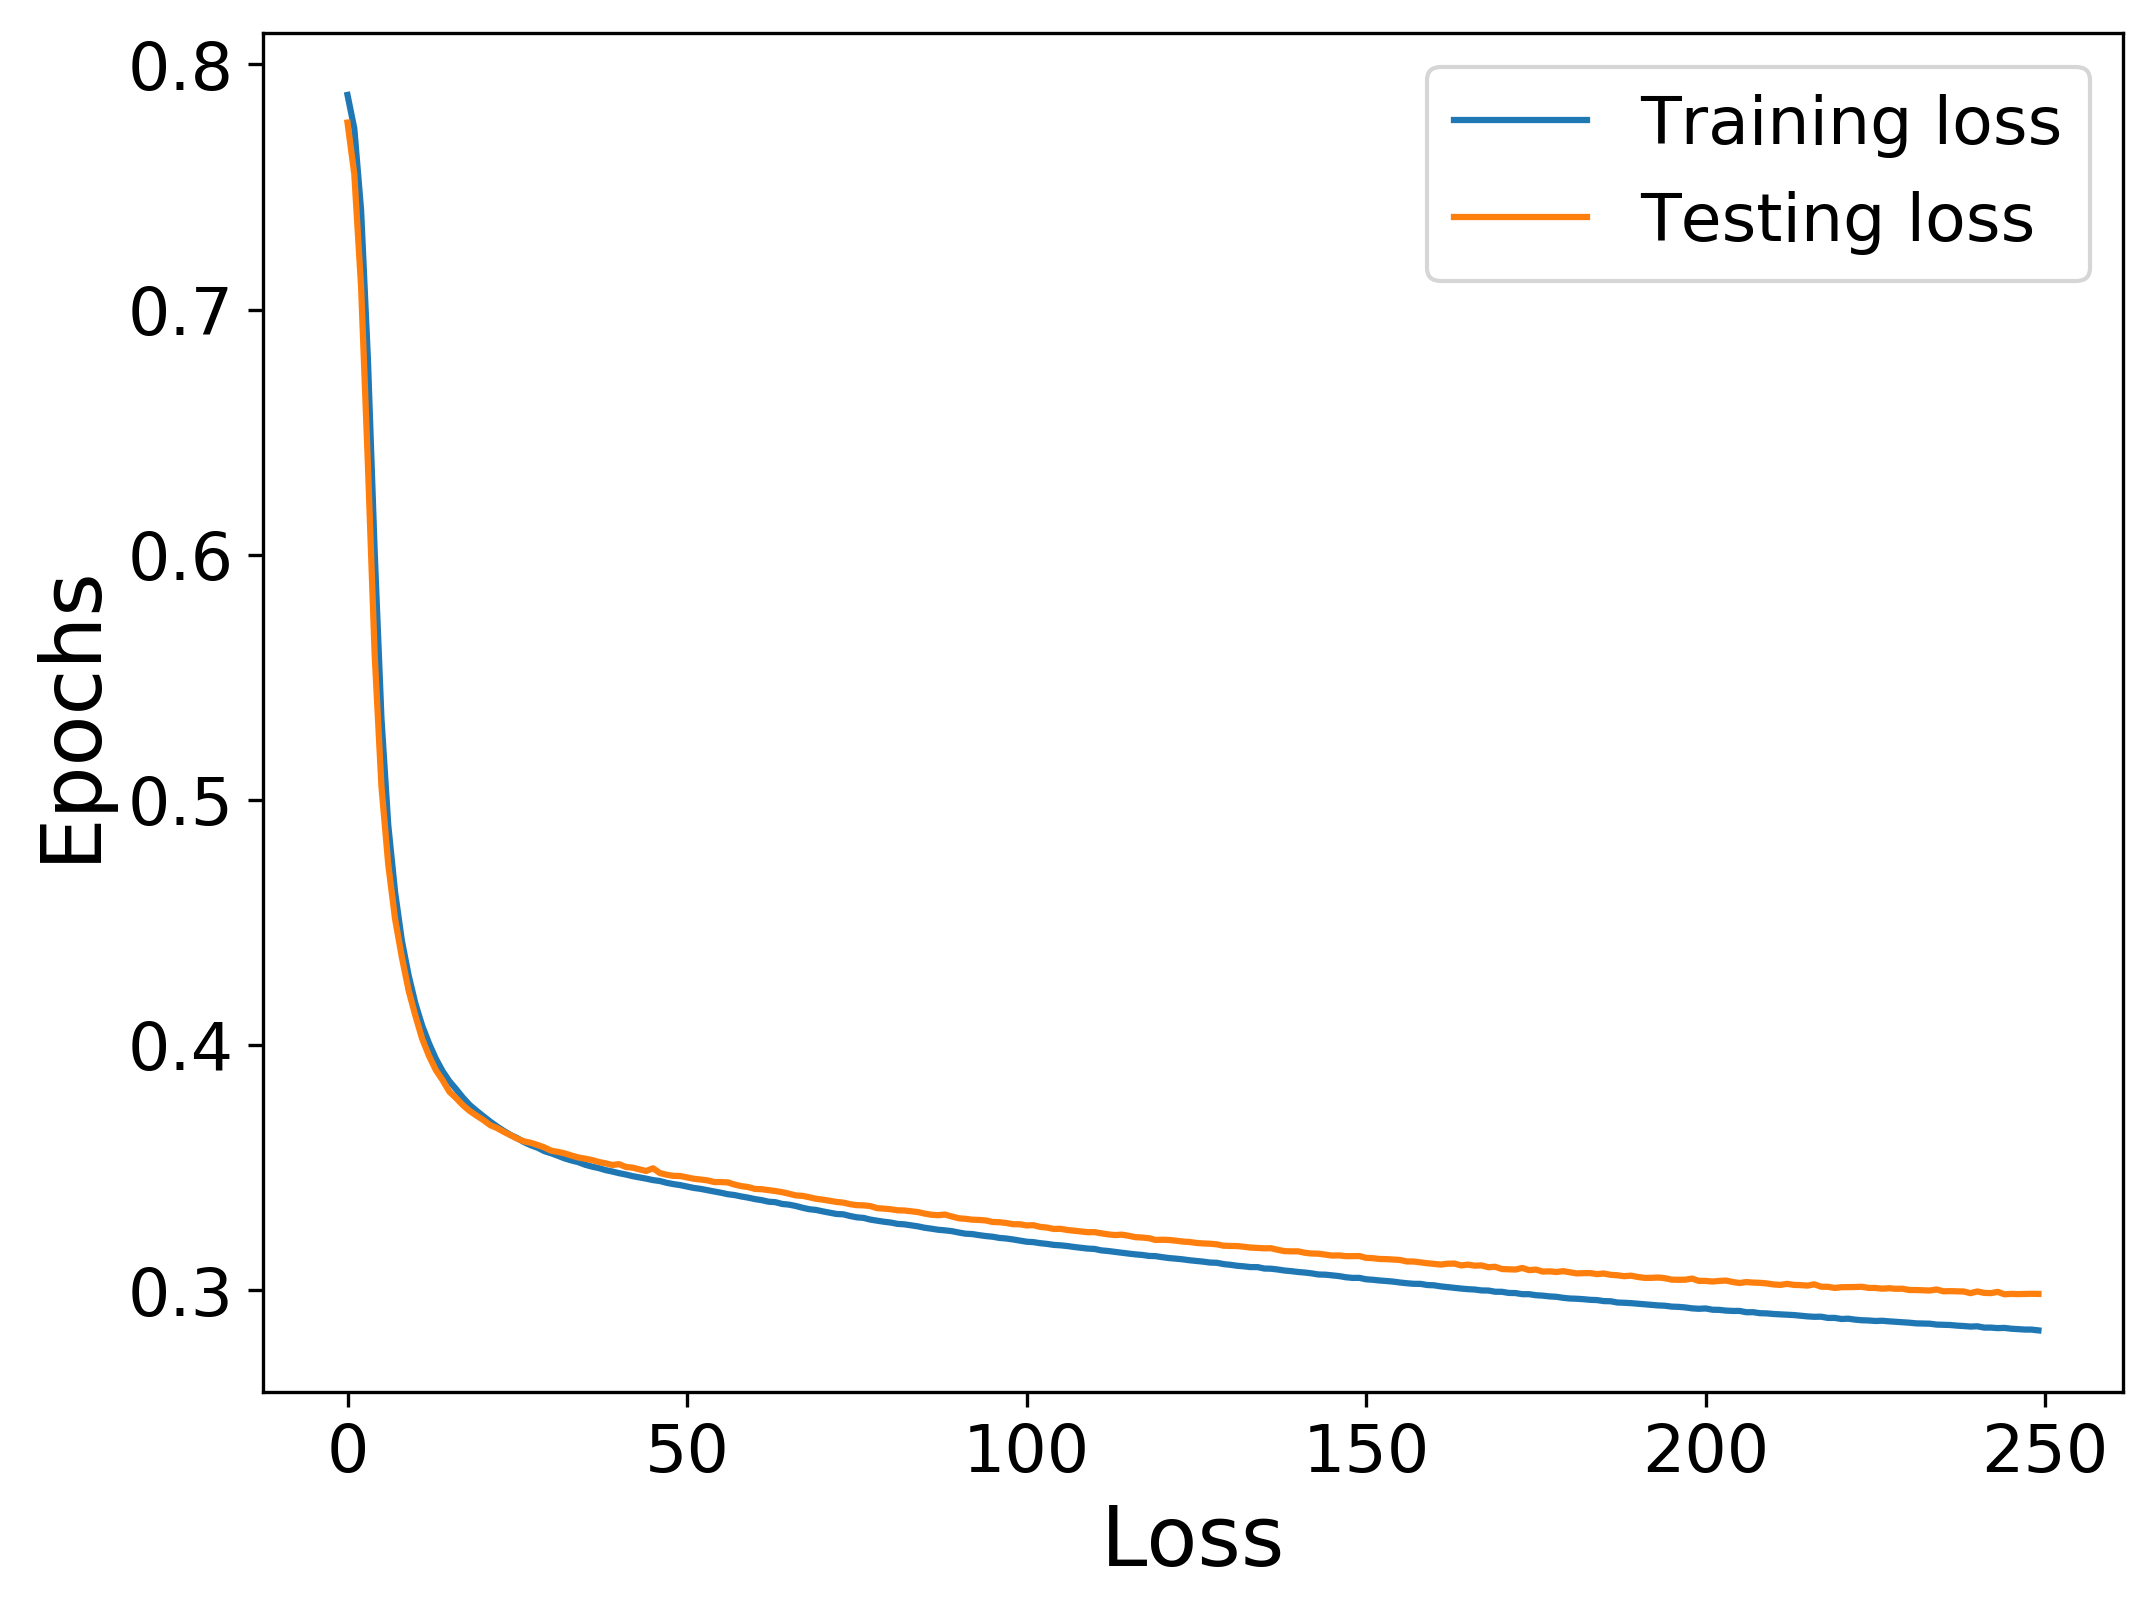

In [31]:
torch.Tensor.ndim = property(lambda self: len(self.shape)) 

fig = plt.figure()
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(training_loss)
plt.plot(testing_loss)
plt.xlabel('Loss', fontsize = 20)
plt.ylabel('Epochs', fontsize = 20)
plt.legend(['Training loss', 'Testing loss'])

if SAVE_PLOT: plt.savefig(PLOT_NAME)

In [32]:
#used to test cpu evaluation time - comment out normally
if CPU:
    model.to('cpu')
else: 
    model.to('cuda')
model.to('cuda')

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1052, bias=True)
  )
)

In [26]:
#compute a validation sample with the trained model

for x, y in val_loader:
    x_sample = x[VALIDATION_ENTRY].to(device)
    y_sample = y[VALIDATION_ENTRY].to(device)

start = time.process_time()
pred = model(x_sample[None])
end = time.process_time()

print('Time to compute: ' + str((end-start)*1000) + 'ms')

if normalize_data:
    x = (x_sample.squeeze().cpu()*input_std + input_mean)
    pred = (pred.squeeze().cpu()*output_std + output_mean)
    y = (y_sample.squeeze().cpu()*output_std + output_mean)
else:
    x = (x_sample.squeeze().cpu())
    pred = (pred.squeeze().cpu())
    y = (y_sample.squeeze().cpu())


Time to compute: 0.3900210000011839ms


In [27]:
# print the solution y from validation data set to a csv
if CSV:
    y_np = y.numpy()
    y_df = pd.DataFrame(y_np)
    y_df.to_csv('data-nn-output/original_' + str(FILE_NUMBER) + '.csv', header=False, index=False)

In [28]:
# print the model prediction pred from validation to a csv
if CSV:
    pred_np = pred.detach().numpy()
    pred_df = pd.DataFrame(pred_np)
    pred_df.to_csv('data-nn-output/nnpred_' + str(FILE_NUMBER) + '.csv', header=False, index=False)

In [29]:
# print the model input from validation set
if CSV:
    x_np = x.detach().numpy()
    x_df = pd.DataFrame(x_np)
    x_df.to_csv('data-nn-output/input_' + str(FILE_NUMBER) + '.csv', header=False, index=False)

In [33]:
#save the trained model
if SAVE: torch.save(model.state_dict(), MODEL_NAME)

In [34]:
#export the model
if EXPORT:
    trained_model = NeuralNetwork()
    dummy = torch.rand([1,9])
    trained_model.load_state_dict(torch.load(MODEL_NAME))
    torch.onnx.export(trained_model, dummy[None], MODEL_NAME + ".onnx", verbose=True)


graph(%0 : Float(1, 1, 9, strides=[9, 9, 1], requires_grad=0, device=cpu),
      %linear_relu_stack.0.weight : Float(64, 9, strides=[9, 1], requires_grad=1, device=cpu),
      %linear_relu_stack.0.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %linear_relu_stack.2.weight : Float(64, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %linear_relu_stack.2.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %linear_relu_stack.4.weight : Float(64, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %linear_relu_stack.4.bias : Float(64, strides=[1], requires_grad=1, device=cpu),
      %linear_relu_stack.6.weight : Float(1052, 64, strides=[64, 1], requires_grad=1, device=cpu),
      %linear_relu_stack.6.bias : Float(1052, strides=[1], requires_grad=1, device=cpu)):
  %9 : Float(1, 9, strides=[9, 1], requires_grad=0, device=cpu) = onnx::Flatten[axis=1](%0) # /home/sehwan/.local/lib/python3.6/site-packages/torch/nn/modules/flatten.py:40:0
  %10 : Flo

In [35]:
example = torch.rand(1,INPUT_NODES)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
if EXPORT_CPP:
    trained_model = NeuralNetwork()
    trained_model.load_state_dict(torch.load(MODEL_NAME))
    print(trained_model)
    sm = torch.jit.trace(trained_model, example)
    # sm = torch.jit.script(model)
    sm.save(MODEL_NAME + ".pt")

sm(torch.ones(1, INPUT_NODES))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1052, bias=True)
  )
)


tensor([[-0.0084, -0.0253, -0.4257,  ..., -0.0128,  0.0012, -0.0051]],
       grad_fn=<AddmmBackward>)